In [ ]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
This file is used to train an ANODE to fit the data for 2 masses on springs experiment.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [ ]:
%%capture
%%bash 
pip install torchdiffeq

In [ ]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--niters', type=int, default=100)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--extra_dim', type=int, default=1)
args = parser.parse_args(args=[])

args.niters = 5000
args.lr = 1e-2
args.nhidden = 80
args.test_freq = 20
args.extra_dim = 0
args.viz = True
args.adjoint = False
args.method = 'dopri5'

In [ ]:
adjoint = False

if args.adjoint == True:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [ ]:
%%capture
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')    

In [ ]:
class OscillatorsDataset(Dataset):
    """
    Dampled Coupled Oscillators synthetic dataset.
    For full details, see damped_oscillators_data.ipynb.
    The code is replicated here to allow imports of the DataLoaders from saved experiments.
    """
    
    def __init__(self, config, train=True, verbose=True):

        # from config
        #   base simulator setup
        self.dt = config['simulator']['dt']
        self.freq = config['simulator']['sampling_freq']
        self.samples = config['simulator']['samples']
        #   system parameter dictionaries
        self.fixed = config['fixed']
        if train:
            self.varying = config['varying']
            self.n = config['train_examples']
        else:
            self.varying = config['eval_varying']
            self.n = config['eval_examples']
        
        # + 1 for the extra sample at t = 0
        self.total_steps = self.freq*self.samples + 1
        # normalised times
        self.times = torch.arange(0,self.samples+1,1)/(1.*self.samples)
        
        if verbose:
            if train:
                print('Training data generation...')
            else:
                print('Evaluation data generation...')
            print('Fixed paramters', self.fixed)
            print('Varying parameters', self.varying)
        
        self.data = []
        # generate data
        for _ in range(self.n):
            description, conditions = self.description_and_conditions()
            output = self.single_run(conditions)
            self.data.append((description, output, self.times))
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n
    
    def description_and_conditions(self):
        """
        Return a sample of initial conditions, with those specified at
        input being fixed and the unspecified being the description, too.
        """
        
        conditions = deepcopy(self.fixed)
        for key in self.varying:
            if key in conditions:
                warnings.warn('System parameter defined in both fixed and varying configs')
            low = min(self.varying[key])
            high = max(self.varying[key])
            conditions[key] = np.random.uniform(low,high)
        
        # the description is the varying part
        description = [conditions[v] for v in self.varying]
        
        return torch.FloatTensor(description), conditions
    
    def single_run(self, conditions):
        x1, x2 = conditions['x1'], conditions['x2']
        v1, v2 = conditions['v1'], conditions['v2']
        m1, m2 = conditions['m1'], conditions['m2']
        c, k = conditions['c'], conditions['k']
        output = []
        for step in range(self.total_steps):
            if step % self.freq == 0:
                output.append([x1,x2,v1,v2])          #Can get rid of v1 and v2 here if I don't care about velocity.
            
            a1 = k*(x2-2*x1) - c*v1
            a2 = k*(x1-2*x2) - c*v2
            
            x1 += self.dt*v1
            x2 += self.dt*v2
            v1 += self.dt*a1
            v2 += self.dt*a2
    
        return torch.FloatTensor(output)

In [ ]:
def visualize(true_y, pred_y):

  """
  """

  if args.viz:
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_x_1 = fig.add_subplot(131, frameon=False)        
    ax_x_2 = fig.add_subplot(132, frameon=False)
    ax_v_1 = fig.add_subplot(133, frameon=False)

    ax_x_1.plot(ts.cpu().detach().numpy(), pred_y[:,0].cpu().detach().numpy(), 'b--', label = 'Predicted')
    ax_x_1.plot(ts.cpu().detach().numpy(), true_y[:,0].cpu().detach().numpy(), 'g-' , label = 'Ground Truth')
    ax_x_1.set_xlabel('Time/s')
    ax_x_1.set_ylabel('$x_1$')
    ax_x_1.legend()


    ax_x_2.plot(ts.cpu().detach().numpy(), pred_y[:,1].cpu().detach().numpy(), 'b--', label = 'Predicted')
    ax_x_2.plot(ts.cpu().detach().numpy(), true_y[:,1].cpu().detach().numpy(), 'g-', label = 'Ground Truth')
    ax_x_2.set_xlabel('Time/s')
    ax_x_2.set_ylabel('$x_2$')
    ax_x_2.legend()

    ax_v_1.plot(ts.cpu().detach().numpy(), pred_y[:,2].cpu().detach().numpy(), 'b--', label = 'Predicted')
    ax_v_1.plot(ts.cpu().detach().numpy(), true_y[:,2].cpu().detach().numpy(), 'g-', label = 'Ground Truth')
    ax_v_1.set_xlabel('Time/s')
    ax_v_1.set_ylabel('$v_1$')
    ax_v_1.legend()

    plt.show()

In [ ]:
train_loader = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/train_loader.pt')
val_loader = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/val_loader.pt')
eval_loader = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/eval_loader.pt')

In [ ]:
def get_ground_truth(func, data_loader):
  """
  """

  i = 0
  for inputs, labels, times in data_loader:
    if i == 0:
      x_1 = labels[0,:,0]
      x_2 = labels[0,:,1]
      v_1 = labels[0,:,2]
      v_2 = labels[0,:,3]
      ts = torch.flatten(times).to(device)
    i += 1

  #For some reason torch.cat() was crashing so used this instead to generate y0.
  y0_data = [x_1[0].item(), x_2[0].item(), v_1[0].item(), v_2[0].item()]
  y0 = torch.tensor(y0_data).to(device)

  true_y = torch.zeros_like(odeint(func, y0, ts, method=args.method))
  true_y[:,0] = x_1
  true_y[:,1] = x_2
  true_y[:,2] = v_1
  true_y[:,3] = v_2
  true_y = true_y.to(device)

  return true_y, y0, ts

In [ ]:
class ODEFunc(nn.Module):
    """
    Defines a neural net to parametrise the ODE.
    """

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(4, args.nhidden),
            nn.Softplus(),
            nn.Linear(args.nhidden, args.nhidden),
            nn.Softplus(),
            nn.Linear(args.nhidden, 4),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


Iter 0001 | Total Loss 0.939328


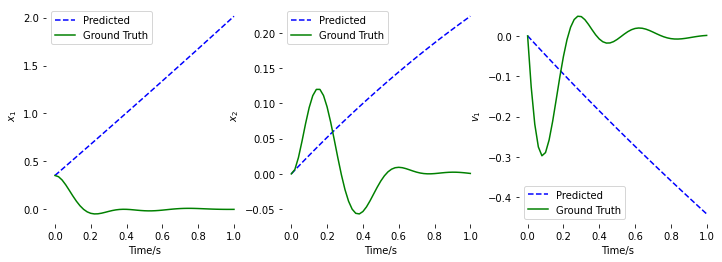

Iteration: 19
Iter 0020 | Total Loss 0.022845


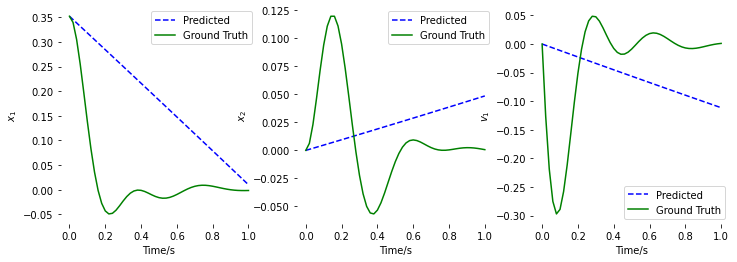

Iteration: 39
Iter 0040 | Total Loss 0.010451


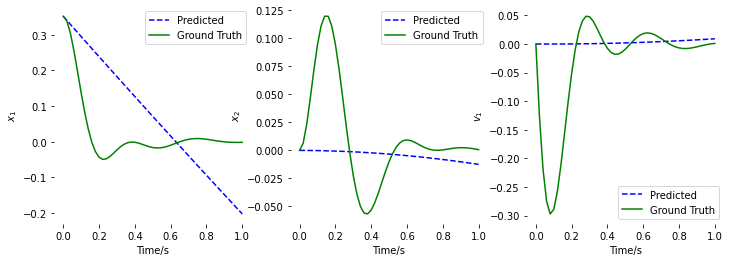

Iteration: 59
Iter 0060 | Total Loss 0.009208


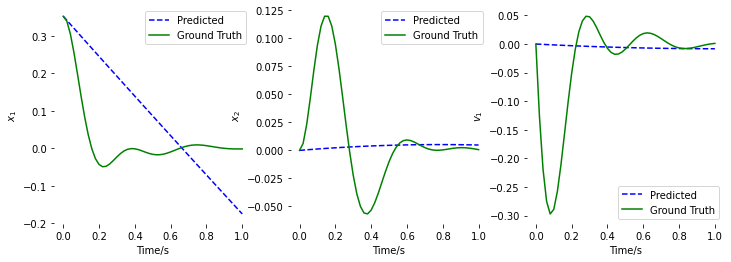

Iteration: 79
Iter 0080 | Total Loss 0.009135


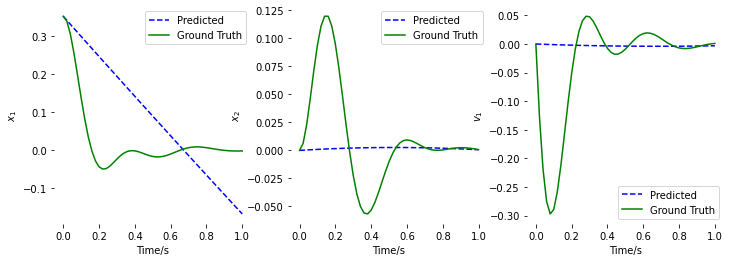

Iteration: 99
Iter 0100 | Total Loss 0.009126


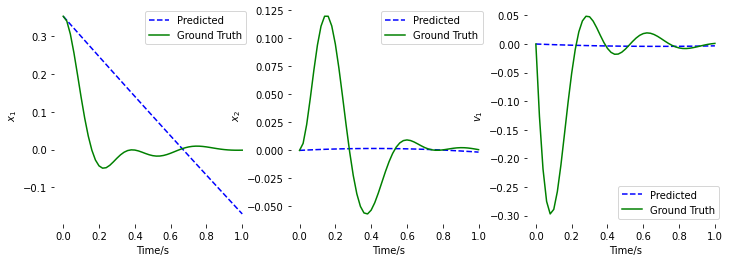

Iteration: 119
Iter 0120 | Total Loss 0.009117


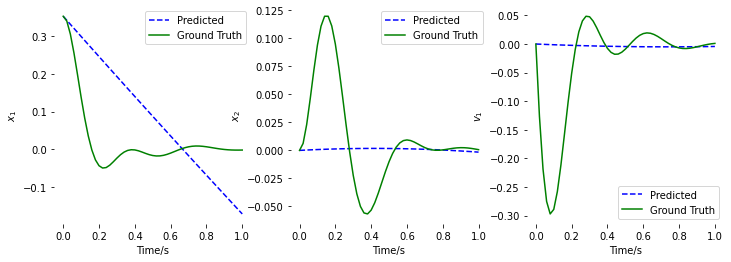

Iteration: 139
Iter 0140 | Total Loss 0.009107


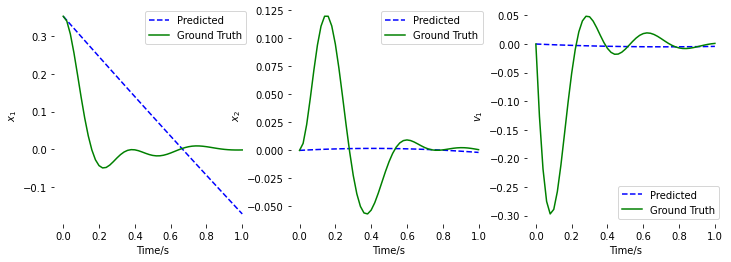

Iteration: 159
Iter 0160 | Total Loss 0.009096


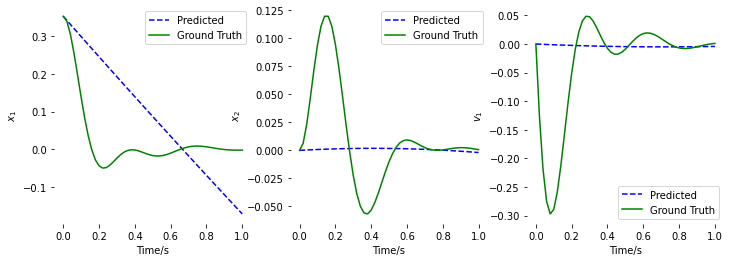

Iteration: 179
Iter 0180 | Total Loss 0.009084


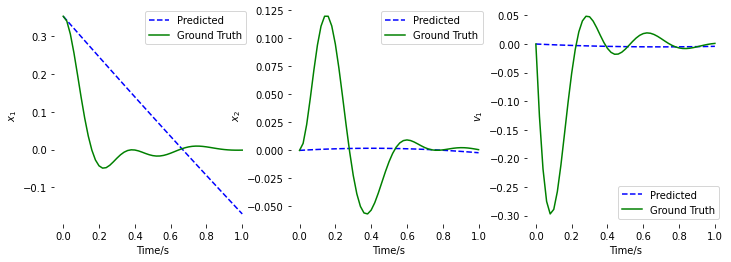

Iteration: 199
Iter 0200 | Total Loss 0.009071


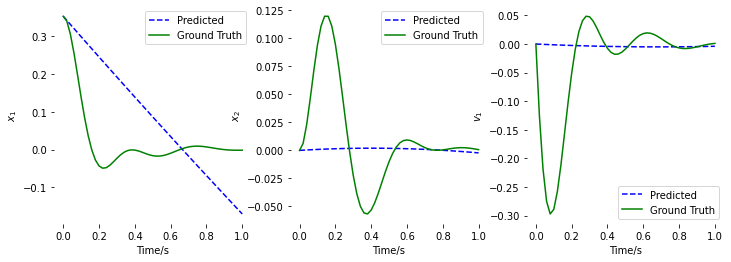

Iteration: 219
Iter 0220 | Total Loss 0.009056


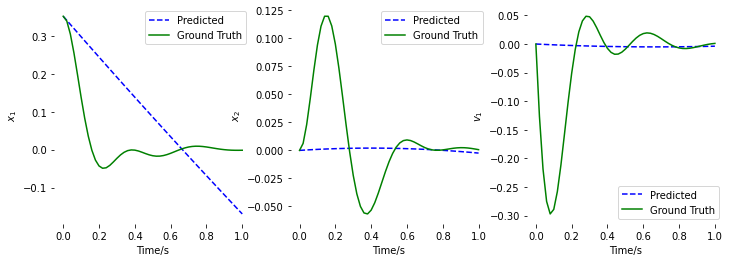

Iteration: 239
Iter 0240 | Total Loss 0.009040


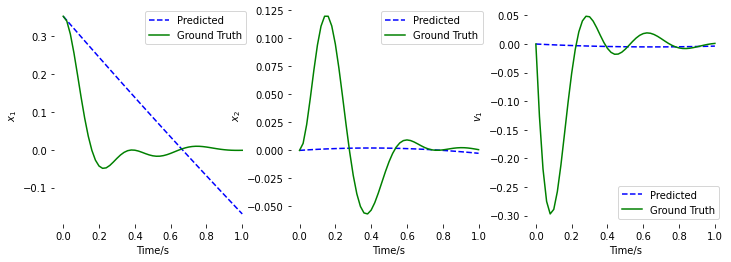

Iteration: 259
Iter 0260 | Total Loss 0.009022


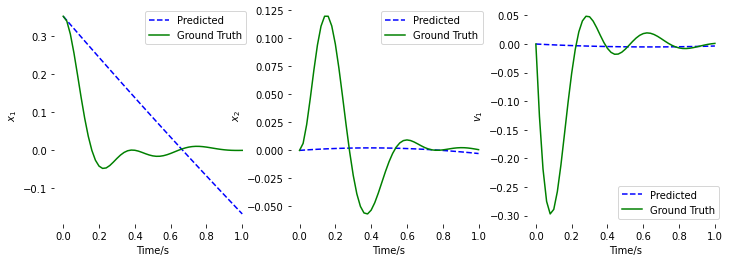

Iteration: 279
Iter 0280 | Total Loss 0.009001


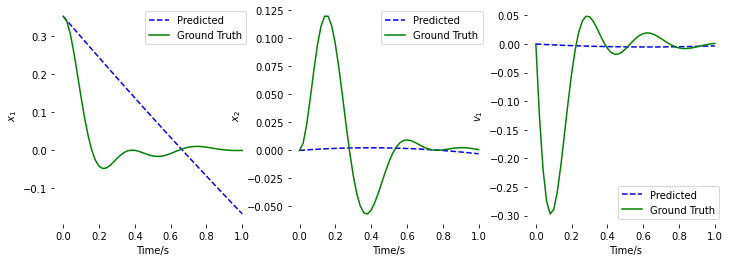

Iteration: 299
Iter 0300 | Total Loss 0.008978


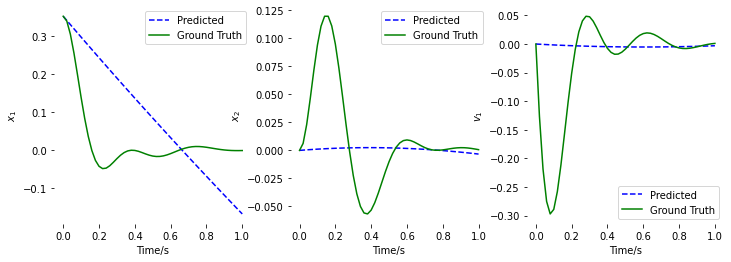

Iteration: 319
Iter 0320 | Total Loss 0.008951


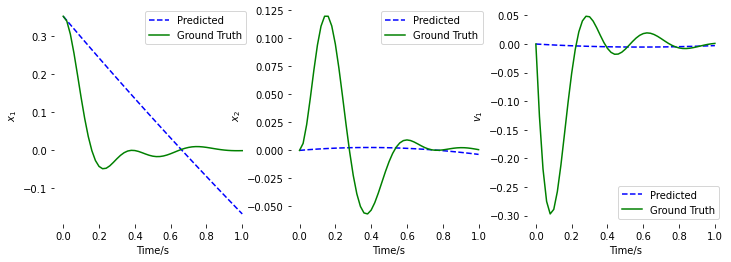

Iteration: 339
Iter 0340 | Total Loss 0.008921


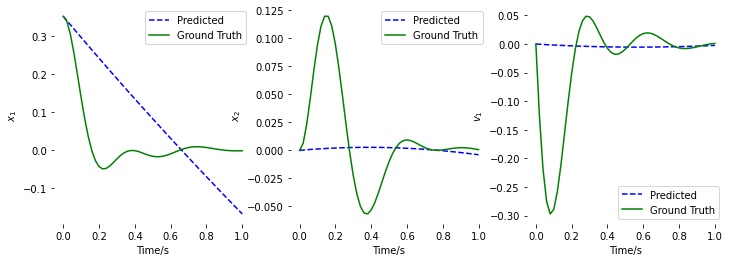

Iteration: 359
Iter 0360 | Total Loss 0.008886


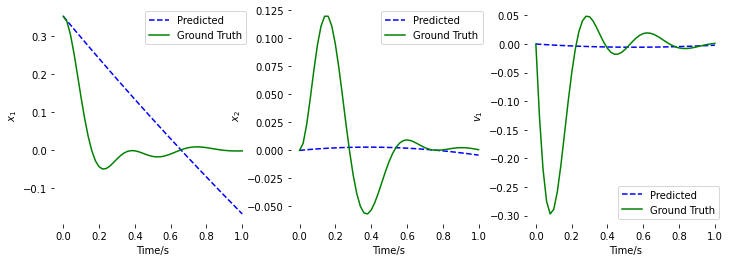

Iteration: 379
Iter 0380 | Total Loss 0.008845


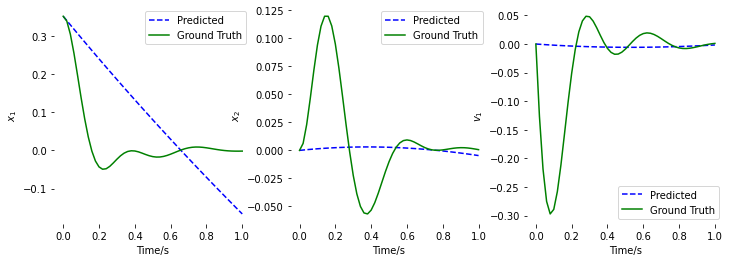

Iteration: 399
Iter 0400 | Total Loss 0.008797


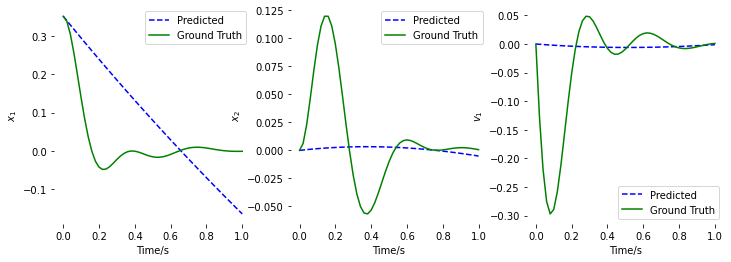

Iteration: 419
Iter 0420 | Total Loss 0.008739


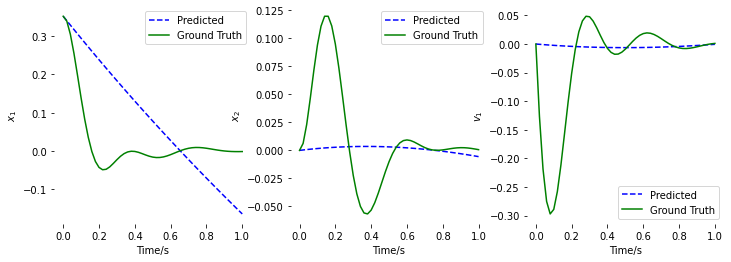

Iteration: 439
Iter 0440 | Total Loss 0.008670


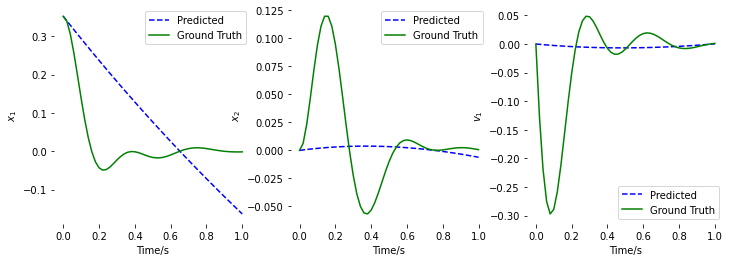

Iteration: 459
Iter 0460 | Total Loss 0.008583


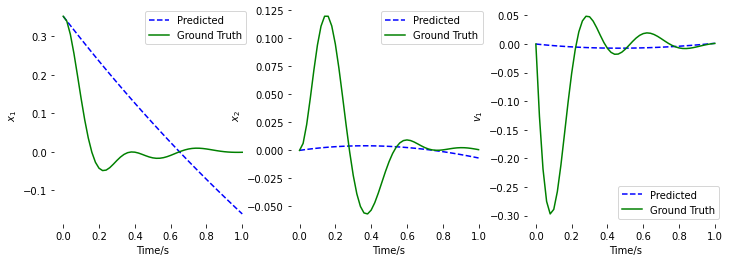

Iteration: 479
Iter 0480 | Total Loss 0.008474


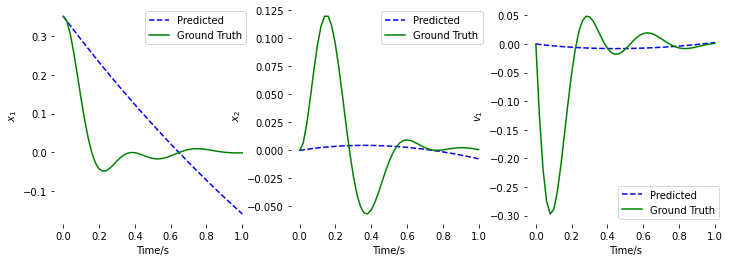

Iteration: 499
Iter 0500 | Total Loss 0.008330


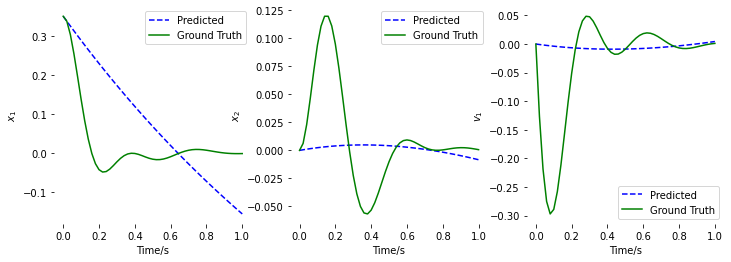

Iteration: 519
Iter 0520 | Total Loss 0.008133


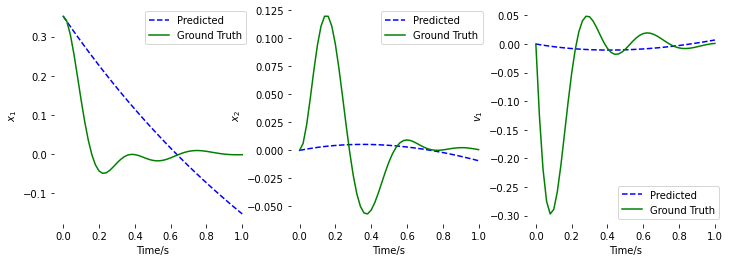

Iteration: 539
Iter 0540 | Total Loss 0.007844


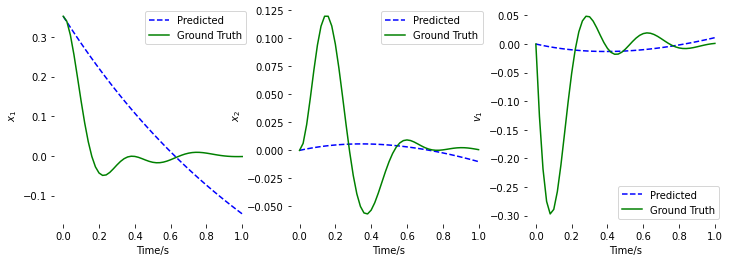

Iteration: 559
Iter 0560 | Total Loss 0.007394


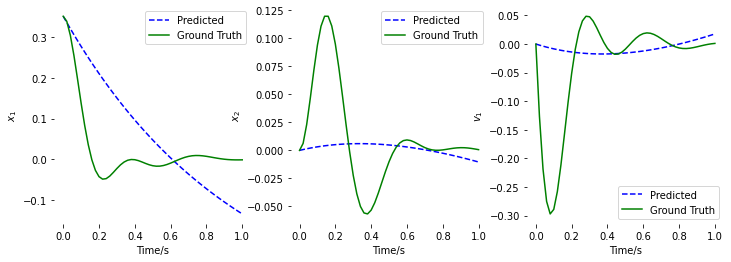

Iteration: 579
Iter 0580 | Total Loss 0.006698


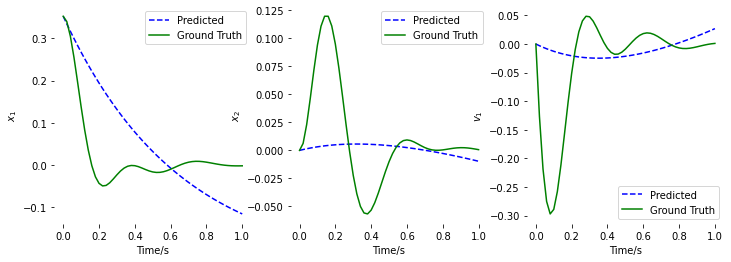

Iteration: 599
Iter 0600 | Total Loss 0.005784


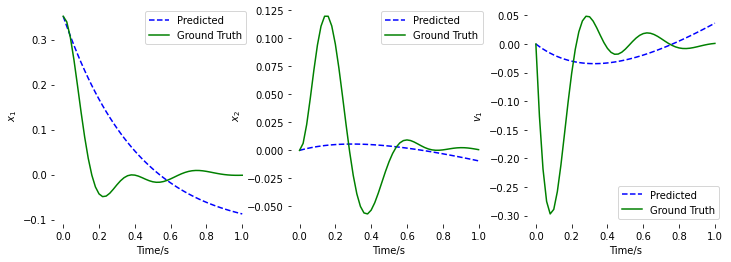

Iteration: 619
Iter 0620 | Total Loss 0.004886


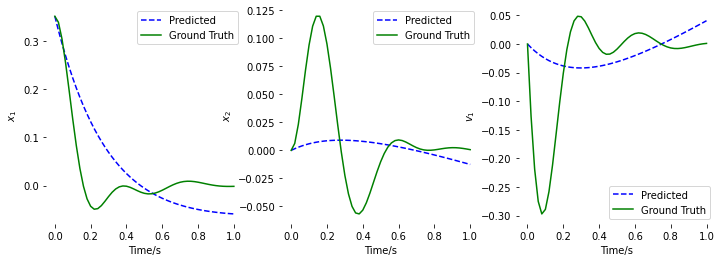

Iteration: 639
Iter 0640 | Total Loss 0.004230


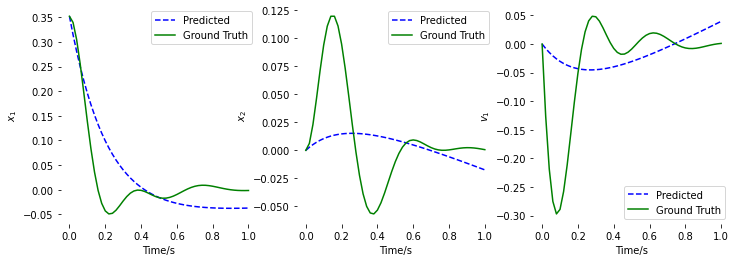

Iteration: 659
Iter 0660 | Total Loss 0.004053


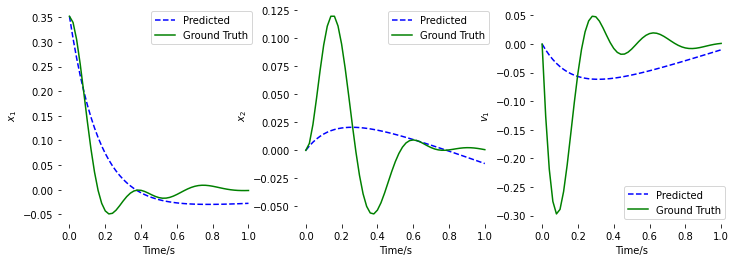

Iteration: 679
Iter 0680 | Total Loss 0.003663


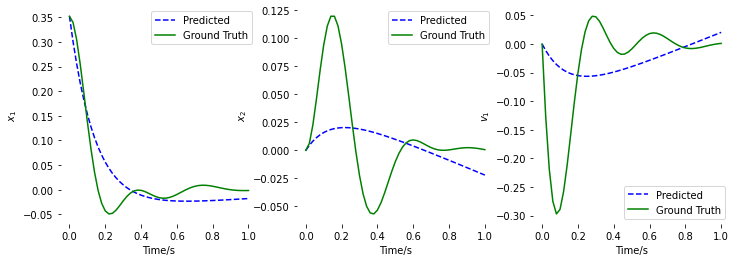

Iteration: 699
Iter 0700 | Total Loss 0.003497


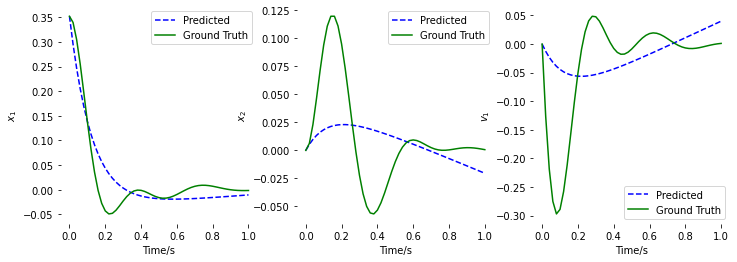

Iteration: 719
Iter 0720 | Total Loss 0.003411


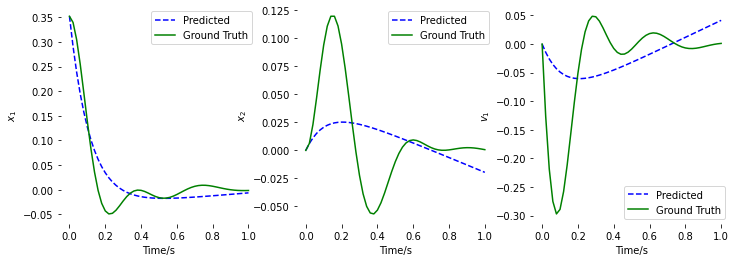

Iteration: 739
Iter 0740 | Total Loss 0.003355


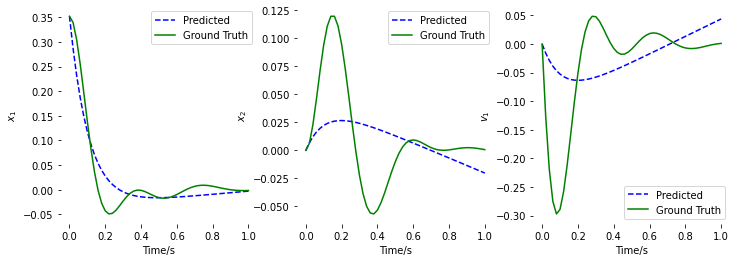

Iteration: 759
Iter 0760 | Total Loss 0.003318


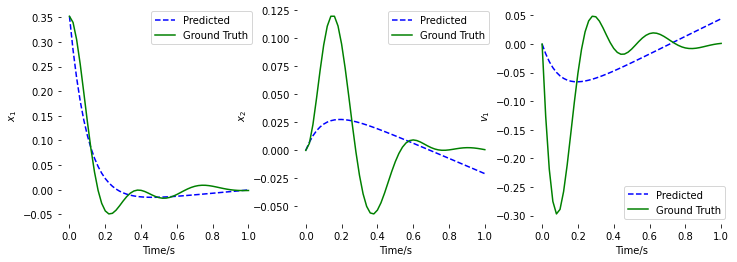

Iteration: 779
Iter 0780 | Total Loss 0.003292


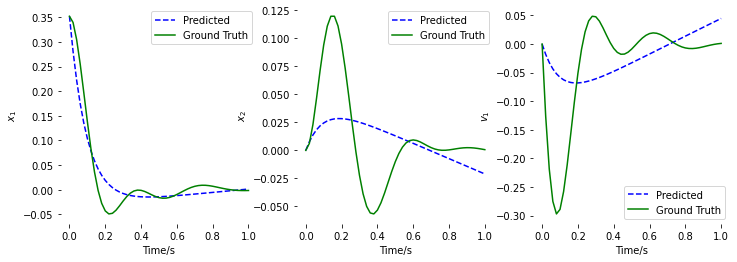

Iteration: 799
Iter 0800 | Total Loss 0.003273


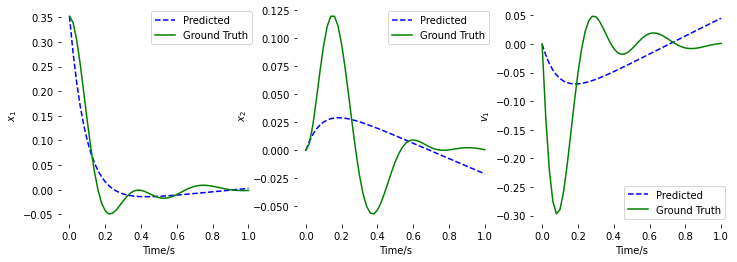

Iteration: 819
Iter 0820 | Total Loss 0.003259


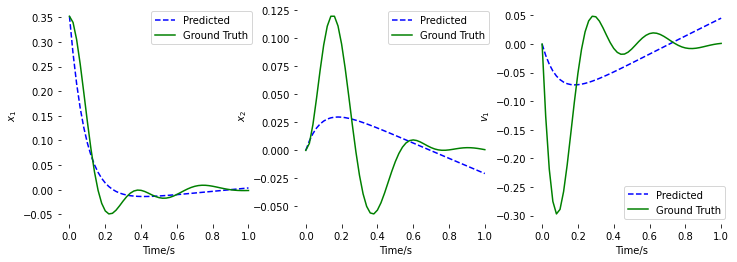

Iteration: 839
Iter 0840 | Total Loss 0.003250


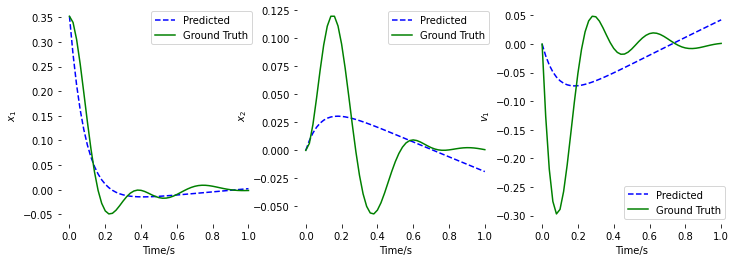

Iteration: 859
Iter 0860 | Total Loss 0.003266


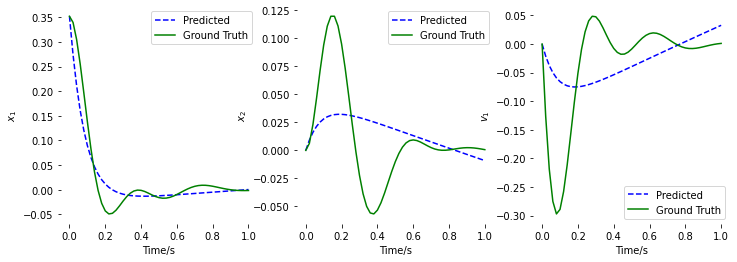

Iteration: 877

In [ ]:
if __name__ == '__main__':
    """
    Executes the programme. This includes doing the following:

      - Trains the network;
      - Outputs the results in a series of png files (if desired);
      - Outputs hessian matrix information in list form.
    """

    ii = 0

    func = ODEFunc().to(device)
    
    optimizer = optim.Adam(func.parameters(), lr=args.lr) 
    loss_data = []

    criterion = nn.MSELoss()

    true_y, y0, ts = get_ground_truth(func, train_loader)

    for itr in range(1, args.niters + 1):
  
        optimizer.zero_grad()                                 
                    
        pred_y = odeint(func, y0, ts, method = args.method)
        loss = criterion(pred_y, true_y)     
        loss.backward() 
      
        if itr % args.test_freq == 0 or itr == 1:
          ii += 1       
          with torch.no_grad():
              loss_data.append((itr, loss.item()))
              print('')
              print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
              visualize(true_y, pred_y)      

        optimizer.step()                                                                   
        print('\rIteration: ' + str(itr), end = '')

In [ ]:
iters = []
losses = []
variation_number = 4
save = False
for item in loss_data:
  iters.append(item[0])
  losses.append(item[1])
plt.figure(figsize=[10,10])
plt.plot(iters, losses)
plt.title('Loss Function for NODE with lr = ' + str(args.lr) 
          + ',\nnhidden = ' + str(args.nhidden) + ', $x_1(0) = $' + str(np.around(x_1[0].item(), decimals=3)))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
if save:
  plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/loss_curve_'
  + str(variation_number) + '.pdf')
plt.show()

NameError: ignored

In [ ]:
torch.save(loss_data, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                      + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                      + '/08_dims/loss_data.pt')

In [ ]:
#Create a plot of the loss curve.
itrs = []
data = []

for item in loss_data:
  itrs.append(item[0])
  data.append(item[1])

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})
plt.plot(itrs, data)
plt.title('Loss function\nGradient Descent'
          + '\nLearning Rate = 1e-3' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
            + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
            + '/08_dims/loss_curve.png')
plt.show()

In [ ]:
odeint()

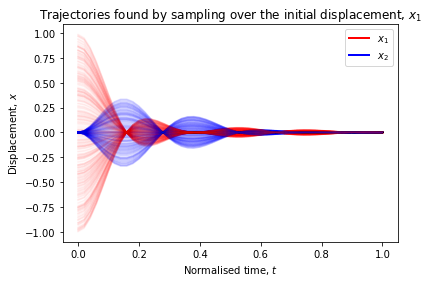

In [ ]:
# sanity plot
save = False

f = plt.figure()

for inputs, labels, times in train_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Trajectories found by sampling over the initial displacement, $x_1$')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$x_1$', '$x_2$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')

if save: 
  f.savefig('varying_x_trajectories.pdf', bbox_inches='tight')

plt.show()